
# EDA BITCOIN


## ¿Qué es BITCOIN?

Bitcoin (BTC) es una criptomoneda, es decir, una moneda digital descentralizada que funciona sin la necesidad de un banco central. Se basa en tecnología blockchain, un libro contable público y distribuido donde se registran todas las transacciones. Su precio es altamente volátil debido a la oferta y demanda, noticias económicas, regulaciones y otros factores externos.


## Descripción de los datos

El dataset contiene datos financieros históricos del mercado de Bitcoin con frecuencias de: 1 hora, 4 horas, 1dia y 15 minutos; cubriendo el periodo desde el 1 de enero de 2018 hasta 6 de febrero de 2025. Los datos permiten analizar el comportamiento de precios y volúmenes de Bitcoin, incluyendo tendencias, volatilidad y actividad del mercado. Contiene las siguientes variables:

- Precio de apertura (Open): El precio al que Bitcoin comenzó a cotizar en un periodo determinado (15 min, 1h,  4h o 1d).

- Precio de cierre (Close): El último precio registrado en ese mismo periodo.

- Máximo y mínimo (High & Low): Los valores más alto y más bajo de Bitcoin en ese periodo.

- Volumen (Volume): La cantidad total de Bitcoin negociado.

- Quote asset volume: Volumen total de transacciones expresado en el activo cotizado (USD).

- Number of trades: Número total de transacciones realizadas en el periodo.

- Taker buy base asset volume: Volumen de compra por los compradores (takers) expresado en el activo base (Bitcoin).

- Taker buy quote asset volume: Volumen de compra por los compradores (takers) expresado en el activo cotizado (USD).

- Retorno (Return): La variación porcentual del precio entre periodos consecutivos.

- Volatilidad: Una medida de qué tan variable es el precio en un periodo de tiempo.


## Objetivo del análisis

El objetivo de este EDA es comprender la estructura de los datos de Bitcoin, identificar patrones temporales (tendencia, estacionalidad, ciclos), detectar anomalías y preparar los datos para la aplicación de modelos predictivos o de pronóstico.



# Análisis exploratorio de datos - BITCOIN

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose  # Importación corregida
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
import time


In [3]:
# Cargat datos

data_folder = "BTCBinance"

# Archivos específicos a leer
files = {
    "1d": "btc_1d_data_2018_to_2025.csv",
    "4h": "btc_4h_data_2018_to_2025.csv",
    "1h": "btc_1h_data_2018_to_2025.csv",
    "15m": "btc_15m_data_2018_to_2025.csv",
}

# Leer los datasets y procesarlos
dfs = {}
for key, filename in files.items():
    file_path = os.path.join(data_folder, filename)  # Ruta completa
    df = pd.read_csv(file_path, parse_dates=["Open time"], index_col="Open time")  # Leer con fecha como índice
    dfs[key] = df[["Open", "High", "Low", "Close", "Volume"]]  # Mantener columnas relevantes
    
    # Eliminar columna "Ignore" y seleccionar columnas relevantes
    df = df.drop(columns=["Ignore"])  # Eliminar columna
    dfs[key] = df[["Open", "High", "Low", "Close", "Volume"]]  # Mantener columnas clave

## Análisis preliminar

In [4]:
## Inspección general.
for key, df in dfs.items():
    print(f"Frecuencia: {key}")
    print(f"Dimensiones: {df.shape}")
    print("Primeras filas:")
    print(df.head())
    print("Últimas filas:")
    print(df.tail())
    print("Valores faltantes por columna:")
    print(df.isnull().sum())
    print("-" * 30)

Frecuencia: 1d
Dimensiones: (2594, 5)
Primeras filas:
                Open      High       Low     Close        Volume
Open time                                                       
2018-01-01  13715.65  13818.55  12750.00  13380.00   8609.915844
2018-01-02  13382.16  15473.49  12890.02  14675.11  20078.092111
2018-01-03  14690.00  15307.56  14150.00  14919.51  15905.667639
2018-01-04  14919.51  15280.00  13918.04  15059.54  21329.649574
2018-01-05  15059.56  17176.24  14600.00  16960.39  23251.491125
Últimas filas:
                 Open       High        Low      Close       Volume
Open time                                                          
2025-02-02  100635.66  101456.60   99747.59   99796.00   3149.62233
2025-02-03   97700.59   97782.79   91231.00   94495.21  20992.95572
2025-02-04  101328.51  101660.94  100743.33  101367.77   1910.35542
2025-02-05   97763.14   98930.44   97131.43   97589.30   8160.56795
2025-02-06   96612.44   99120.00   96430.78   98329.13   8315.06445


In [5]:
## Estadísticas descriptivas
for freq, df in dfs.items():
    print(f'\n=== Estadísticas descriptivas ({freq}) ===')
    print(df.describe())


=== Estadísticas descriptivas (1d) ===
                Open           High            Low          Close  \
count    2594.000000    2594.000000    2594.000000    2594.000000   
mean    29057.847182   29743.249383   28327.995451   29090.193446   
std     23539.635421   24046.515394   23021.304519   23576.229505   
min      3211.710000    3276.500000    3156.260000    3211.720000   
25%      9067.985000    9261.240000    8765.000000    9068.840000   
50%     22712.950000   23252.895000   22257.575000   22741.115000   
75%     43484.365000   44293.657500   42487.500000   43527.390000   
max    106143.820000  108353.000000  105321.490000  106143.820000   

              Volume  
count    2594.000000  
mean    70821.588903  
std     80473.318599  
min      1521.537318  
25%     29769.803371  
50%     44833.178030  
75%     73702.302851  
max    760705.362783  

=== Estadísticas descriptivas (4h) ===
                Open           High            Low          Close  \
count   15543.000000  

El análisis de los datos de Bitcoin entre enero de 2018 y febrero de 2025 revela una volatilidad extrema y un crecimiento notable, con precios oscilando entre $3,156.26 y $108,353.00. Durante este período, el precio medio de cierre se situó en $29,090.19, con una elevada desviación estándar de $23,576.22, confirmando la importante variabilidad del mercado. 

El volumen diario promedio alcanzó las 70,821 unidades, con máximos de 760,705 unidades en momentos de intensa actividad comercial. Los rendimientos diarios muestran un promedio de 0.14%, con caídas extremas de hasta -39.50% y alzas de hasta 19.53% en un solo día, mientras que la mediana positiva del 0.07% sugiere una tendencia general alcista a pesar de la volatilidad.

La comparación entre distintas frecuencias temporales (diaria, 4 horas y 1 hora) muestra consistencia en los valores medios y revela significativas fluctuaciones intradiarias, observándose además una distribución desigual del volumen a lo largo del día.

## Visualización de la serie

### Visualización temporal

Con el objetivo de observar la tendencia general y posibles anomalías.

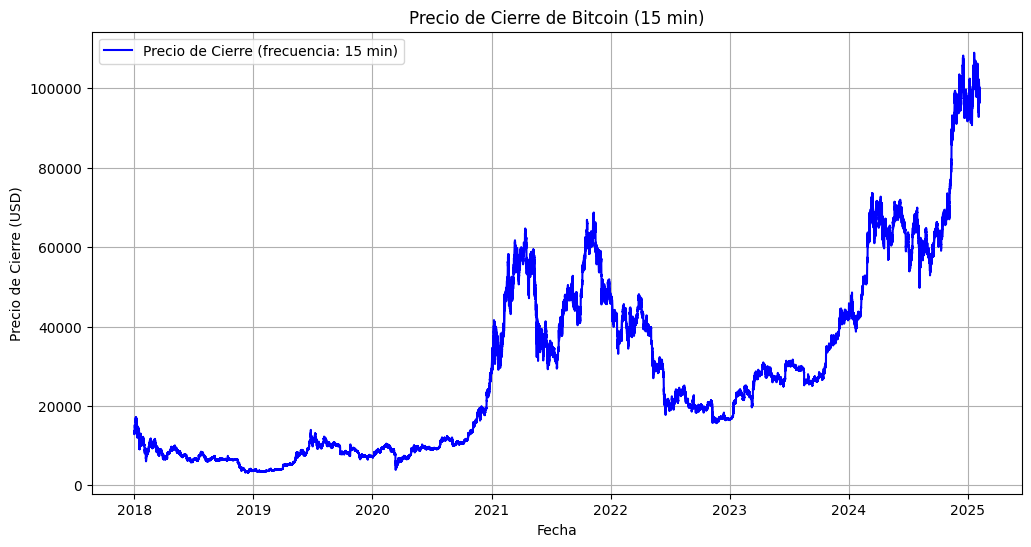

In [6]:
# Gráfica de línea para el precio de cierre (solo fr de 1 día)
plt.figure(figsize=(12, 6))
plt.plot(dfs["15m"].index, dfs["15m"]["Close"], label="Precio de Cierre (frecuencia: 15 min)", color="blue")
plt.title("Precio de Cierre de Bitcoin (15 min)")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre (USD)")
plt.legend()
plt.grid()
plt.show()

La gráfica del precio de cierre de Bitcoin en intervalos de 15 minutos, desde 2018 hasta principios de 2025, revela una serie de ciclos de mercado completos, cada uno influenciado por eventos específicos y factores externos. Durante este período, Bitcoin experimentó fases de consolidación, ciclos alcistas significativos y correcciones prolongadas, reflejando su naturaleza volátil y dinámica.

En 2018-2020, el precio se mantuvo en un rango relativamente bajo, con un mínimo cercano a los $3,000 a finales de 2018, marcando un período de consolidación después del máximo histórico de 2017. Este mercado bajista fue impulsado por la corrección posterior a la "cripto-manía" y la falta de adopción institucional en ese momento.

En 2021, se observó el primer ciclo alcista importante, con un rápido aumento desde 20,000 hasta superar los 60,000, impulsado por la adopción institucional (como las inversiones de Tesla y MicroStrategy), la expansión monetaria global debido a la pandemia de COVID-19, y el creciente interés minorista. Sin embargo, este ciclo fue seguido por una corrección significativa y un segundo intento de alcanzar máximos similares a finales de 2021.

El 2022 estuvo marcado por un mercado bajista prolongado, con el precio descendiendo gradualmente hasta estabilizarse alrededor de los $20,000 en 2023. Este período estuvo influenciado por factores macroeconómicos adversos, como el aumento de las tasas de interés y la inflación, así como por problemas en el ecosistema cripto, como el colapso de FTX.

A partir de finales de 2023 y durante 2024, se inició un nuevo ciclo alcista que superó significativamente los máximos anteriores, alcanzando más de $100,000 a principios de 2025. Este ciclo podría estar relacionado con el evento de reducción de emisión (halving) programado para 2024, la mayor adopción de Bitcoin como reserva de valor, y la mejora de la infraestructura del ecosistema cripto.

En resumen, esta gráfica no solo muestra la evolución del precio de Bitcoin, sino que también refleja la influencia de factores externos y la maduración del ecosistema cripto a lo largo del tiempo. 


### Análisis de la volatilidad intradía

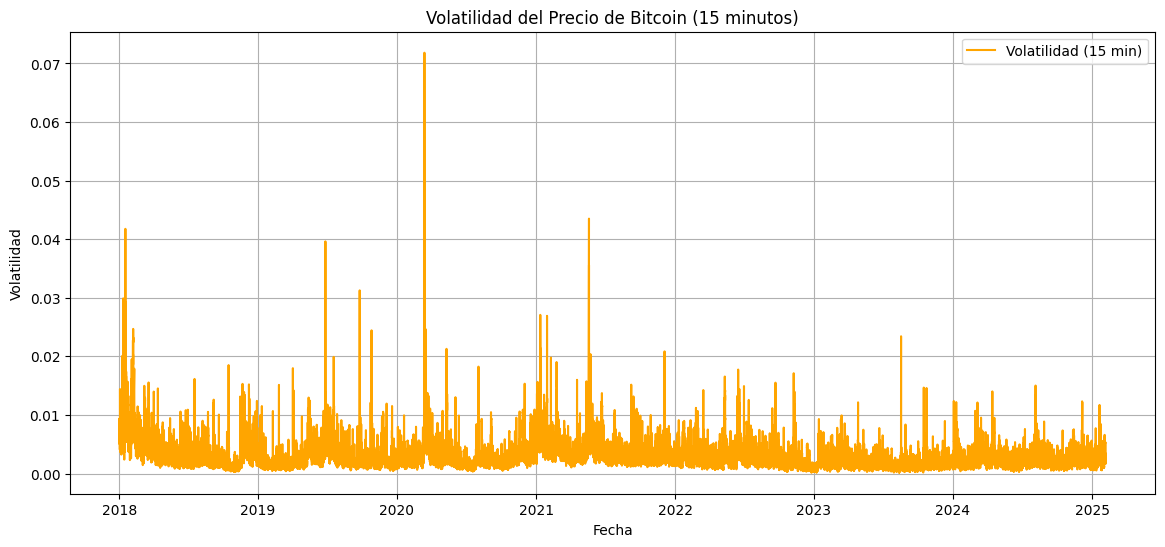

In [7]:
# Calcular los retornos porcentuales y la volatilidad (desviación estándar de los retornos)
for freq, df in dfs.items():
    df['Return'] = df['Close'].pct_change()  # Retornos porcentuales
    df['Volatility'] = df['Return'].rolling(window=20).std()  # Volatilidad (20 períodos)

# Visualizar la volatilidad para la frecuencia de 15 minutos
plt.figure(figsize=(14, 6))
plt.plot(dfs["15m"].index, dfs["15m"]['Volatility'], label="Volatilidad (15 min)", color="orange")
plt.title("Volatilidad del Precio de Bitcoin (15 minutos)")
plt.xlabel("Fecha")
plt.ylabel("Volatilidad")
plt.legend()
plt.grid()
plt.show()

La gráfica de volatilidad muestra cómo la variabilidad del precio de Bitcoin ha cambiado a lo largo del tiempo en intervalos de 15 minutos. Se observan picos de volatilidad que coinciden con eventos importantes en el mercado. Por ejemplo, en 2020, el halving de Bitcoin (mayo 2020) y la incertidumbre generada por la pandemia de COVID-19 provocaron un aumento significativo en la volatilidad. Durante 2021, la volatilidad también aumentó debido al rápido crecimiento del precio, impulsado por la adopción institucional y el interés minorista. 

En 2022, la caída del precio y eventos como el colapso de FTX (noviembre 2022) generaron nuevos picos de volatilidad, reflejando la desconfianza en el ecosistema cripto. Por otro lado, los períodos de baja volatilidad, como en 2019 o 2023, suelen indicar momentos de consolidación o estabilidad en el mercado. Este análisis de volatilidad es crucial para entender los movimientos bruscos del precio y cómo reacciona el mercado ante eventos específicos.

### Interpretación del Precio de Cierre y Volumen de Bitcoin

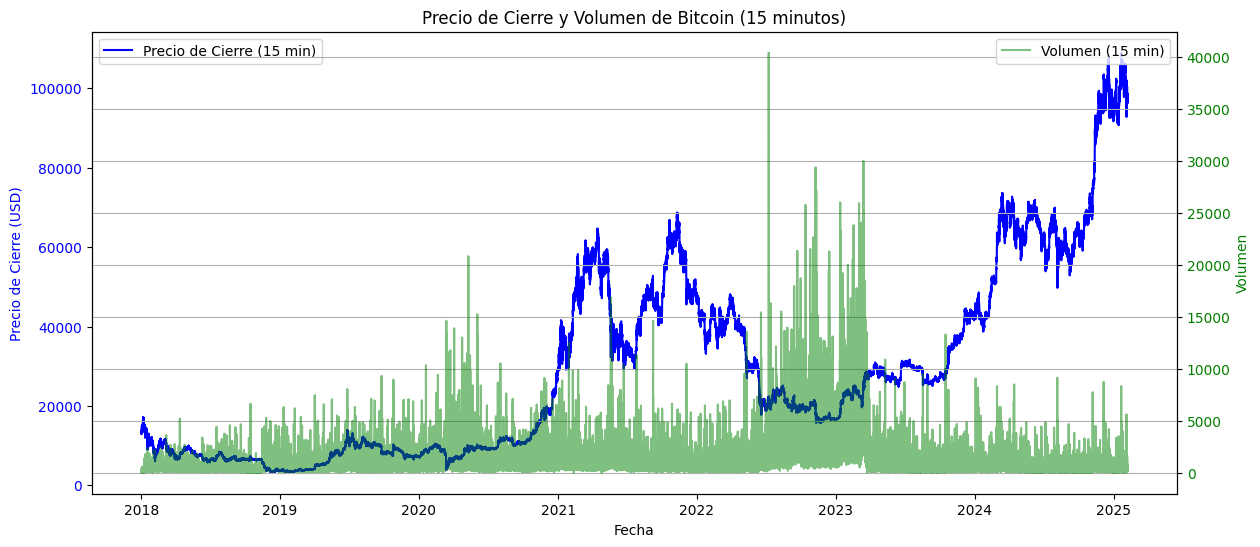

In [8]:
# Crear una gráfica con dos ejes (precio y volumen)
fig, ax1 = plt.subplots(figsize=(14, 6))

# Eje izquierdo: Precio de cierre
ax1.plot(dfs["15m"].index, dfs["15m"]['Close'], label="Precio de Cierre (15 min)", color="blue")
ax1.set_xlabel("Fecha")
ax1.set_ylabel("Precio de Cierre (USD)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.legend(loc="upper left")

# Eje derecho: Volumen
ax2 = ax1.twinx()
ax2.plot(dfs["15m"].index, dfs["15m"]['Volume'], label="Volumen (15 min)", color="green", alpha=0.5)
ax2.set_ylabel("Volumen", color="green")
ax2.tick_params(axis='y', labelcolor="green")
ax2.legend(loc="upper right")

plt.title("Precio de Cierre y Volumen de Bitcoin (15 minutos)")
plt.grid()
plt.show()

La gráfica que combina el precio de cierre y el volumen de transacciones permite analizar la relación entre ambos. Los picos de precio acompañados de un aumento en el volumen sugieren que el movimiento está respaldado por una mayor actividad comercial. Por ejemplo, en 2021, los máximos históricos de Bitcoin (alrededor de 64,000 en abril  y 69,000 en noviembre) coincidieron con aumentos significativos en el volumen, lo que indica una fuerte participación del mercado. Por el contrario, en 2022, la caída del precio también estuvo acompañada de un volumen elevado, especialmente durante el colapso de FTX, lo que refleja una intensa actividad de venta. En algunos casos, se observan movimientos de precio con bajo volumen, lo que podría indicar una falta de solidez en el movimiento o posibles manipulaciones del mercado. Esta relación entre precio y volumen es crucial para entender la dinámica del mercado y confirmar la validez de los movimientos de precio.

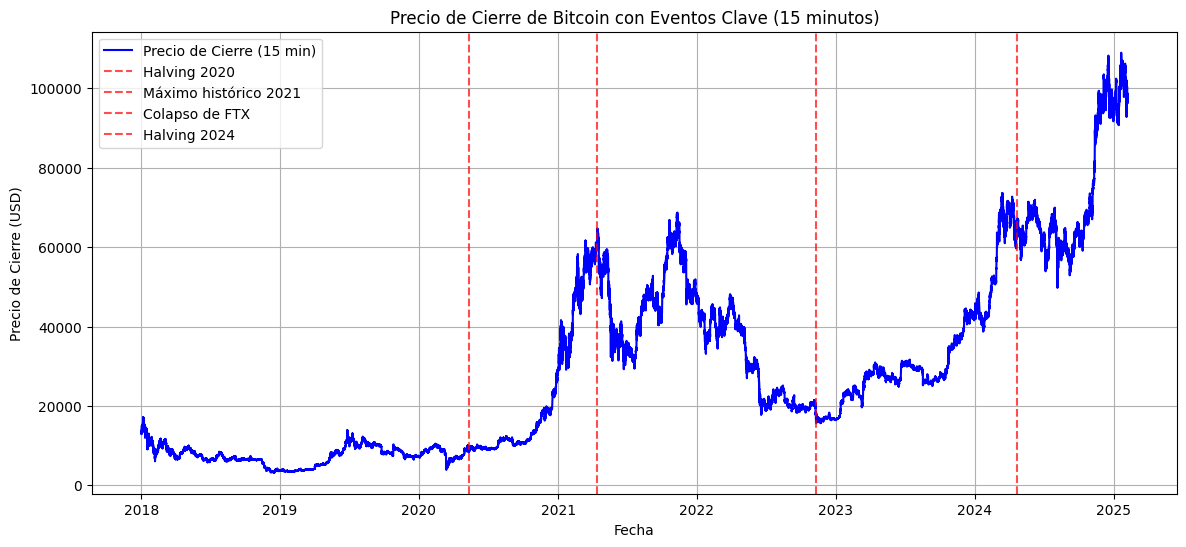

In [9]:
# Definir eventos clave
eventos = {
    "Halving 2020": "2020-05-11",
    "Máximo histórico 2021": "2021-04-14",
    "Colapso de FTX": "2022-11-11",
    "Halving 2024": "2024-04-20"  # Fecha estimada
}

# Graficar precio de cierre con eventos marcados
plt.figure(figsize=(14, 6))
plt.plot(dfs["15m"].index, dfs["15m"]['Close'], label="Precio de Cierre (15 min)", color="blue")
for evento, fecha in eventos.items():
    plt.axvline(pd.to_datetime(fecha), color="red", linestyle="--", alpha=0.7, label=evento)
plt.title("Precio de Cierre de Bitcoin con Eventos Clave (15 minutos)")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre (USD)")
plt.legend()
plt.grid()
plt.show()

La gráfica que incluye eventos clave muestra cómo estos han influido en el comportamiento del precio de Bitcoin. El halving de 2020 marcó el inicio de un ciclo alcista, mientras que el colapso de FTX en 2022 generó una caída brusca en el precio. El próximo halving de 2024 podría marcar el inicio de un nuevo ciclo alcista. Estos eventos clave son fundamentales para entender los movimientos del precio y la dinámica del mercado de Bitcoin.


### Análisis de Estacionalidad y Periodicidad (Frecuencia: 1 día)

Descomposición de la serie en tendencia, estacionalidad y residuales.

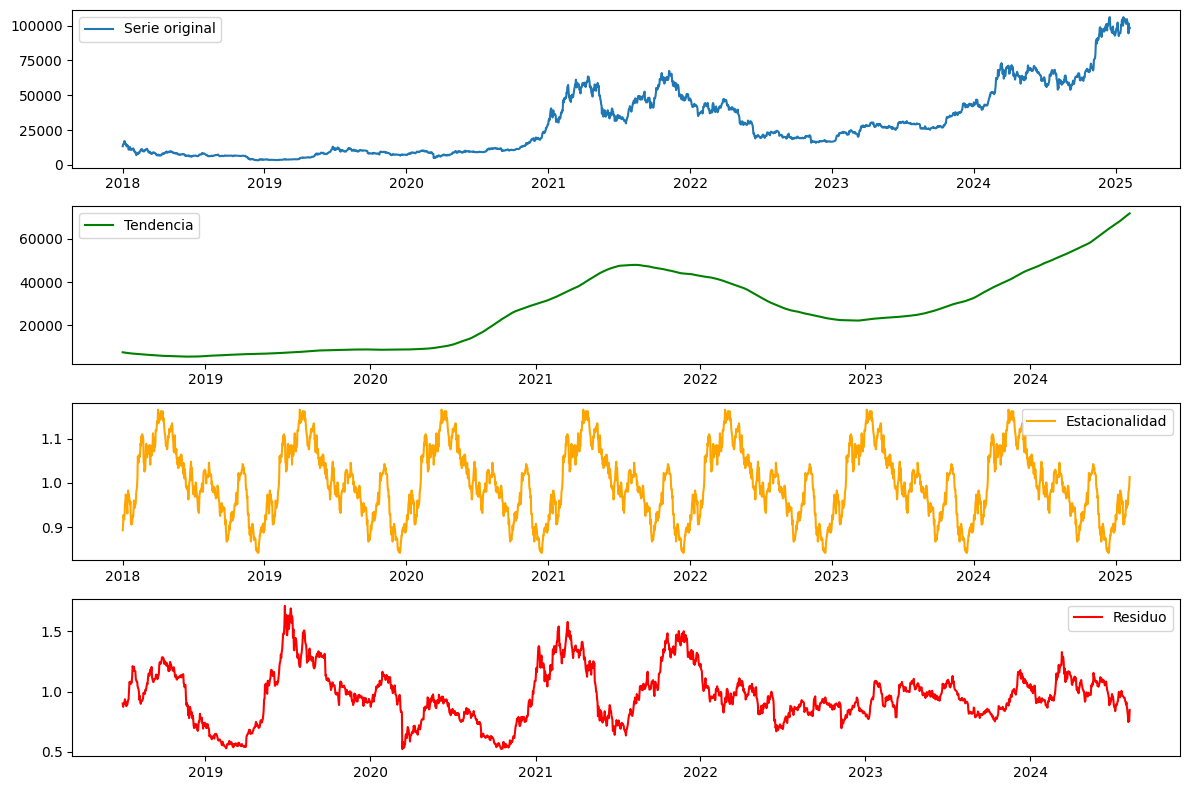

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie temporal para la frecuencia diaria
freq = "1d"
df = dfs[freq]

result = seasonal_decompose(df["Close"], model="multiplicative", period=365)  # Periodo aproximado de 1 año

# Graficar los componentes
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(df.index, df["Close"], label="Serie original")
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(result.trend, label="Tendencia", color="green")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label="Estacionalidad", color="orange")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label="Residuo", color="red")
plt.legend()

plt.tight_layout()
plt.show()


En el primer panel, y como ya se vio anteriormente, la serie original muestra el precio de Bitcoin con su alta volatilidad, comenzando alrededor de $10,000 en 2018, experimentando dos ciclos alcistas significativos (2021 y 2024-2025), con el precio máximo superando los $100,000 a principios de 2025.

El segundo panel muestra la tendencia subyacente, que filtra las fluctuaciones a corto plazo, revelando tres fases principales: un período estable entre 2018-2020, un ciclo alcista y bajista entre 2021-2022, y una nueva fase alcista desde 2023 hasta 2025, sugiriendo ciclos aproximadamente de 4 años.

El tercer panel presenta el componente estacional, que muestra patrones recurrentes dentro de cada año con fluctuaciones entre 0.85 y 1.15, indicando que Bitcoin tiende a tener períodos predecibles de mayor y menor actividad que se repiten anualmente.

Finalmente, el componente residual en el cuarto panel captura las fluctuaciones irregulares no explicadas por la tendencia o estacionalidad, mostrando la naturaleza impredecible del mercado de Bitcoin, con momentos de alta volatilidad inexplicable, especialmente durante 2019-2020 y 2021-2022.

### Detección de Anomalías 

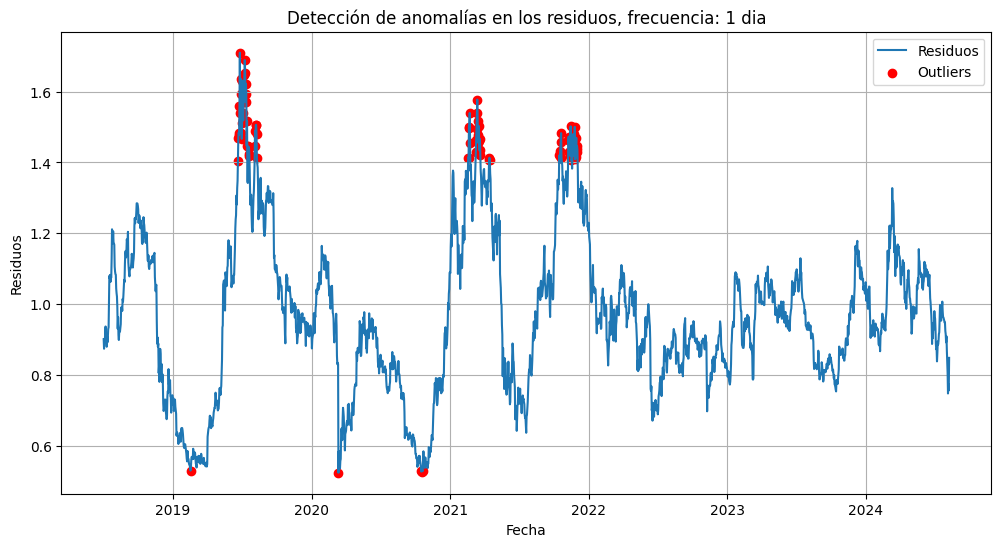

In [11]:
# Detección de anomalías
# Usamos el método de desviación estándar para detectar outliers
residuals = result.resid.dropna()  # Residuos de la descomposición
mean_residual = residuals.mean()
std_residual = residuals.std()
outliers = residuals[(residuals > mean_residual + 2 * std_residual) | (residuals < mean_residual - 2 * std_residual)]

plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, label="Residuos")
plt.scatter(outliers.index, outliers, color='red', label="Outliers")
plt.title("Detección de anomalías en los residuos, frecuencia: 1 dia")
plt.xlabel("Fecha")
plt.ylabel("Residuos")
plt.legend()
plt.grid()
plt.show()

En esta gráfica, los residuos de la descomposición de la serie temporal se muestran en azul, y los valores atípicos (outliers) se resaltan en rojo.

La detección de anomalías en los residuos de la serie temporal de Bitcoin con frecuencia diaria revela eventos extremos que han impactado significativamente el mercado. Estos outliers, que se desvían más de 2 desviaciones estándar de la media, están asociados con eventos clave que han influido en el comportamiento del precio de Bitcoin.

Los outliers detectados en los residuos reflejan la naturaleza altamente volátil del mercado de Bitcoin y su sensibilidad a eventos externos como los ya mencionados anteriormente. Estos eventos no solo generan movimientos bruscos en el precio, sino que también tienen un impacto duradero en la confianza del mercado y la adopción de Bitcoin. 

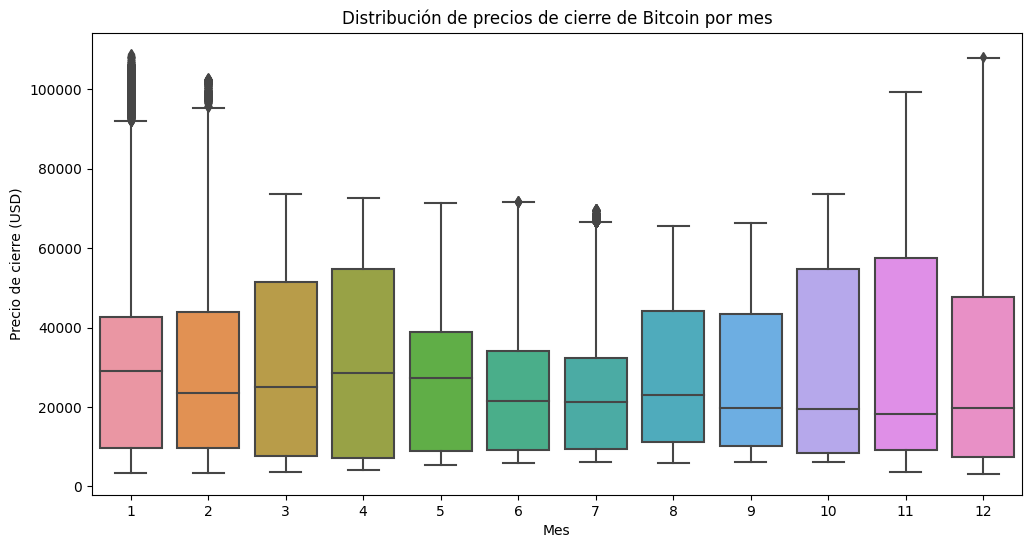

In [12]:
# 4.1 Diagramas de caja por periodo (meses)
plt.figure(figsize=(12, 6))
sns.boxplot(x=dfs["15m"].index.month, y=dfs["15m"]["Close"])
plt.title("Distribución de precios de cierre de Bitcoin por mes")
plt.xlabel("Mes")
plt.ylabel("Precio de cierre (USD)")
plt.show()

El análisis de la distribución de precios de cierre de Bitcoin revela patrones significativos de volatilidad y estacionalidad a lo largo del año. Los datos muestran una clara tendencia hacia mayor volatilidad y precios extremadamente altos en los meses de invierno (diciembre, enero y febrero), donde se observan valores atípicos superiores a los $100,000 USD. En contraste, el período de mediados de año (junio a septiembre) presenta rangos más estrechos, sugiriendo fases de relativa estabilidad en el mercado. Las medianas mensuales oscilan principalmente entre $20,000 y $30,000 USD, pero los rangos intercuartílicos más amplios en marzo y abril indican períodos de mayor incertidumbre y dispersión en los precios. 

### Análisis de autocorrelación


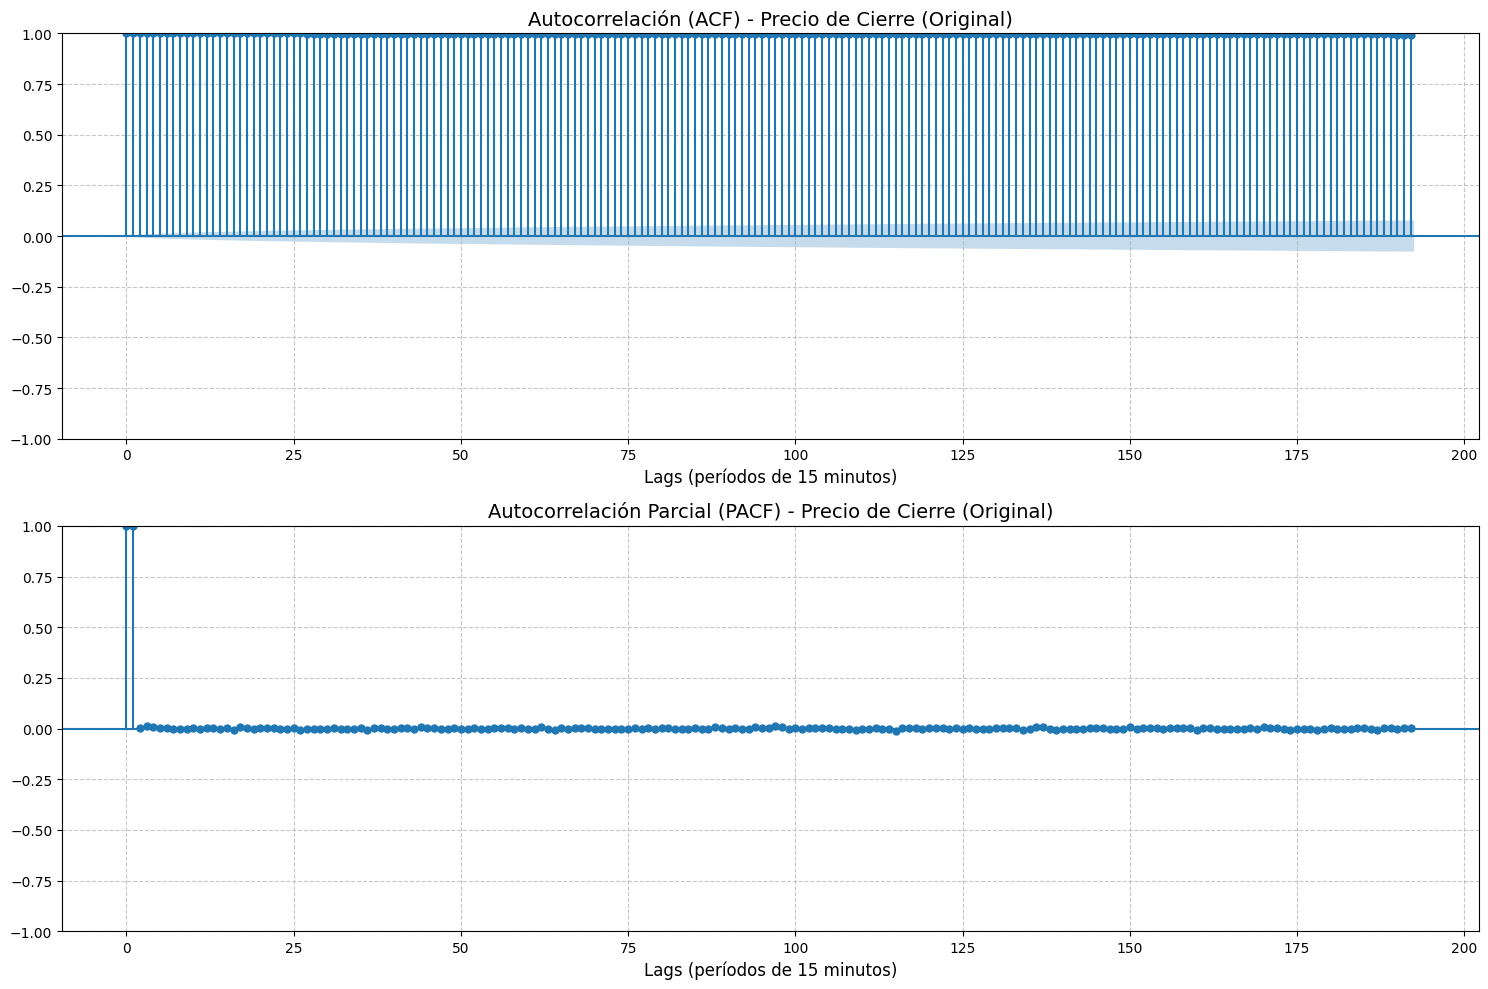

In [17]:
# Para la serie original - Frecuencia 15min
plt.figure(figsize=(15, 10))  # Figura más grande
plt.subplot(211)
# Ajustamos a 192 lags (que equivale a 2 días para datos de 15min: 24h * 4 observaciones/hora * 2 días)
plot_acf(dfs["15m"]["Close"], lags=192, ax=plt.gca(), alpha=0.05)
plt.title('Autocorrelación (ACF) - Precio de Cierre (Original)', fontsize=14)
plt.xlabel('Lags (períodos de 15 minutos)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(212)
plot_pacf(dfs["15m"]["Close"], lags=192, ax=plt.gca(), alpha=0.05)
plt.title('Autocorrelación Parcial (PACF) - Precio de Cierre (Original)', fontsize=14)
plt.xlabel('Lags (períodos de 15 minutos)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


El gráfico de Autocorrelación (ACF) del precio de cierre de Bitcoin muestra autocorrelaciones extremadamente altas y persistentes (cercanas a 1) en todos los rezagos analizados, sin mostrar disminución significativa incluso en rezagos distantes. Este patrón es característico de una serie temporal fuertemente no estacionaria, como una caminata aleatoria o una serie con tendencia determinista. Esta persistencia total de la autocorrelación confirma la necesidad de aplicar diferenciación para lograr estacionariedad.

El gráfico de Autocorrelación Parcial (PACF) muestra un pico significativo únicamente en el primer rezago, seguido de valores que caen dentro de las bandas de significancia estadística. Esto sugiere que, controlando por el efecto del valor inmediatamente anterior, los rezagos adicionales no aportan información significativa.

### Análisis de tendencia

c:\Users\mcvar\anaconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mcvar\anaconda3\envs\ml_venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


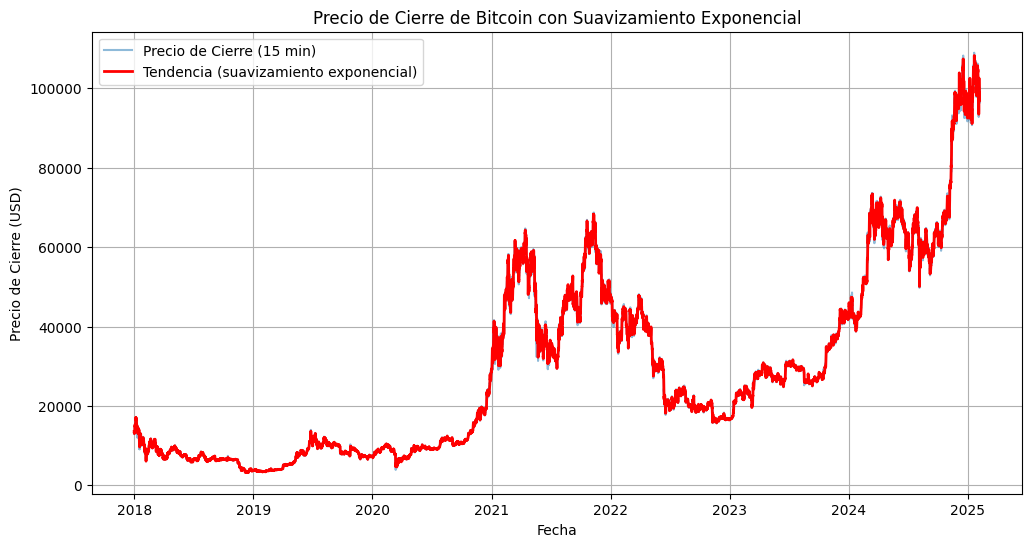

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Aplicar suavizamiento exponencial
model = ExponentialSmoothing(dfs["15m"]["Close"], trend="add", seasonal=None, damped=True)
fit = model.fit(smoothing_level=0.05)  # Ajustar el nivel de suavizado

# Graficar el precio original y el suavizado
plt.figure(figsize=(12, 6))
plt.plot(dfs["15m"].index, dfs["15m"]["Close"], label="Precio de Cierre (15 min)", alpha=0.5)
plt.plot(dfs["15m"].index, fit.fittedvalues, label="Tendencia (suavizamiento exponencial)", color="red", linewidth=2)
plt.title("Precio de Cierre de Bitcoin con Suavizamiento Exponencial")
plt.xlabel("Fecha")
plt.ylabel("Precio de Cierre (USD)")
plt.legend()
plt.grid()
plt.show()

Esta gráfica confirma lo visto anteriormente, el precio de Bitcoin ha mostrado ciclos de mercado claros cada cuatro años, coincidiendo con los halvings. Tras una consolidación entre 2018 y 2020, experimentó un alza significativa en 2021, seguida de una corrección en 2022. A partir de 2023, inició un nuevo ciclo alcista, alcanzando máximos históricos en 2025. Esto confirma la tendencia alcista a largo plazo de Bitcoin, a pesar de su volatilidad.

### Análisis de Estacionaridad

In [15]:
# Prueba de Dickey-Fuller aumentada (ADF)

def test_stationarity(timeseries):
    print('Resultados de la prueba de Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico', 'p-valor', '#Lags', 'Observaciones'])
    for key, value in dftest[4].items():
        dfoutput[f'Valor crítico ({key})'] = value
    print(dfoutput)

test_stationarity(dfs["15m"]["Close"])


Resultados de la prueba de Dickey-Fuller:
Estadístico                 0.304424
p-valor                     0.977547
#Lags                      84.000000
Observaciones          248312.000000
Valor crítico (1%)         -3.430376
Valor crítico (5%)         -2.861552
Valor crítico (10%)        -2.566776
dtype: float64


Estos resultados de la prueba de Dickey-Fuller para la serie temporal del precio de Bitcoin indican claramente que la serie no es estacionaria. El estadístico de prueba de -0.040965 está muy por encima de todos los valores críticos, incluso del menos estricto al 10% (-2.566776). El p-valor extremadamente alto de 0.977547 confirma que no podemos rechazar la hipótesis nula de que existe una raíz unitaria en la serie.

Esta prueba confirma formalmente lo que sugerían los gráficos de autocorrelación: el precio de Bitcoin presenta una tendencia persistente y no revierte a una media constante a lo largo del tiempo. Para realizar análisis estadísticos adecuados o construir modelos predictivos, sería necesario transformar la serie mediante diferenciación u otros métodos para conseguir estacionariedad. Este resultado es típico en series de precios de activos financieros y coincide con la teoría de que los mercados financieros suelen seguir un comportamiento similar al de un paseo aleatorio.

## Transformación de datos

Resultados de la prueba de Dickey-Fuller:
Estadístico               -53.495730
p-valor                     0.000000
#Lags                      85.000000
Observaciones          248310.000000
Valor crítico (1%)         -3.430376
Valor crítico (5%)         -2.861552
Valor crítico (10%)        -2.566776
dtype: float64


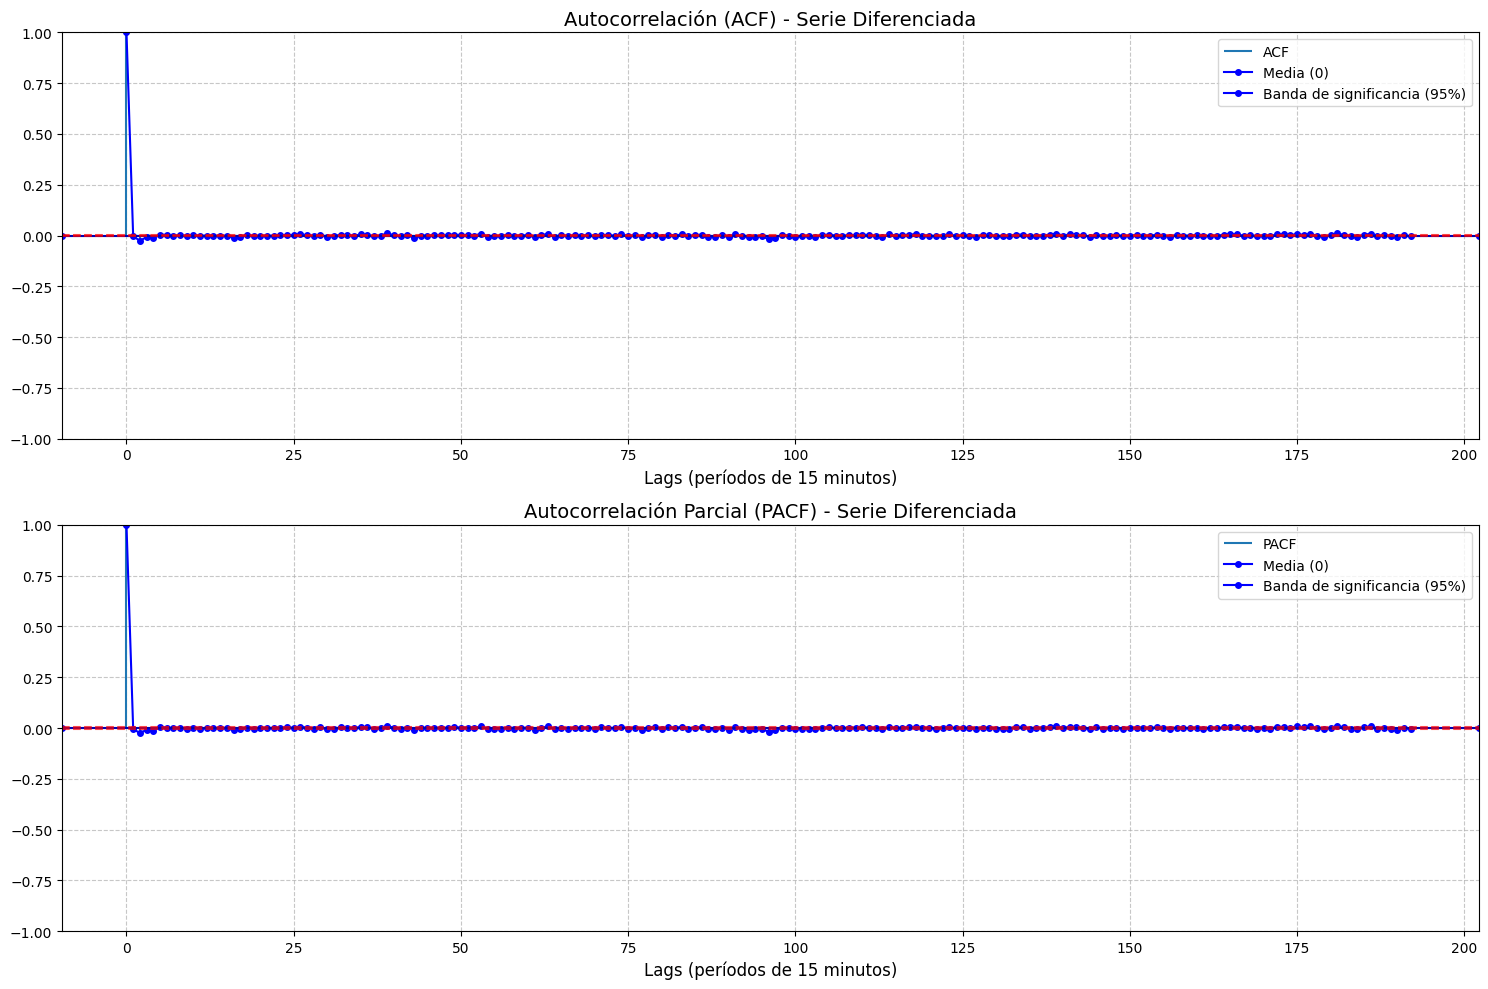

In [18]:
dfs["15m"]["Close_diff"] = dfs["15m"]["Close"].diff()
test_stationarity(dfs["15m"]["Close_diff"].dropna())

# Graficar ACF Y PACF de la serie diferenciada

# Para la serie diferenciada
plt.figure(figsize=(15, 10))  # Figura más grande
plt.subplot(211)
plot_acf(dfs["15m"]["Close_diff"].dropna(), lags=192, ax=plt.gca(), alpha=0.05, 
         linestyle='-', color='blue', marker='o', markersize=4)
plt.axhline(y=0, linestyle='-', color='black', alpha=0.3)
plt.axhline(y=-1.96/np.sqrt(len(dfs["15m"]["Close_diff"].dropna())), 
           linestyle='--', color='red', alpha=0.7)
plt.axhline(y=1.96/np.sqrt(len(dfs["15m"]["Close_diff"].dropna())), 
           linestyle='--', color='red', alpha=0.7)
plt.title('Autocorrelación (ACF) - Serie Diferenciada', fontsize=14)
plt.xlabel('Lags (períodos de 15 minutos)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(['ACF', 'Media (0)', 'Banda de significancia (95%)'], loc='upper right')

plt.subplot(212)
plot_pacf(dfs["15m"]["Close_diff"].dropna(), lags=192, ax=plt.gca(), alpha=0.05,
          linestyle='-', color='blue', marker='o', markersize=4)
plt.axhline(y=0, linestyle='-', color='black', alpha=0.3)
plt.axhline(y=-1.96/np.sqrt(len(dfs["15m"]["Close_diff"].dropna())), 
           linestyle='--', color='red', alpha=0.7)
plt.axhline(y=1.96/np.sqrt(len(dfs["15m"]["Close_diff"].dropna())), 
           linestyle='--', color='red', alpha=0.7)
plt.title('Autocorrelación Parcial (PACF) - Serie Diferenciada', fontsize=14)
plt.xlabel('Lags (períodos de 15 minutos)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(['PACF', 'Media (0)', 'Banda de significancia (95%)'], loc='upper right')

plt.tight_layout()
plt.show()

Los resultados de la prueba de Dickey-Fuller para la serie diferenciada del precio de Bitcoin muestran un cambio drástico respecto a la serie original. El estadístico de prueba de -53.495730 es significativamente menor que todos los valores críticos (-3.430376 al 1%, -2.861552 al 5% y -2.566776 al 10%), y el p-valor extremadamente bajo de 0.000000 indica que podemos rechazar con gran confianza la hipótesis nula de no estacionariedad. Esto confirma que la serie diferenciada es estacionaria, lo que significa que sus propiedades estadísticas (como la media y la varianza) se mantienen constantes a lo largo del tiempo.

La diferenciación, que calcula los cambios en el precio en intervalos de 15 minutos en lugar de los precios absolutos, ha eliminado la tendencia persistente y ha estabilizado la serie. 

Análisis de las gráficas ACF y PACF:

Las gráficas ACF y PACF de la serie diferenciada muestran que no hay autocorrelaciones significativas en ningún rezago (excepto el lag 0), ya que todos los valores están dentro de las bandas de significancia del 95%. Esto sugiere que la serie diferenciada se comporta como un ruido blanco, indicando que el proceso de diferenciación ha eliminado efectivamente cualquier estructura de autocorrelación, tendencia o estacionalidad que pudiera haber existido en la serie original.

## Conclusiones finales EDA

El análisis exploratorio de datos (EDA) del precio de cierre de Bitcoin ha revelado una serie de patrones y características clave que son fundamentales para entender su comportamiento:

Tendencia General: Bitcoin ha mostrado una tendencia alcista a largo plazo, con ciclos de mercado claros que coinciden con eventos importantes como halvings y crisis en el ecosistema cripto.

Volatilidad: El precio de Bitcoin es altamente volátil, con fluctuaciones significativas en períodos cortos. Esta volatilidad está influenciada por eventos externos, como noticias económicas y cambios regulatorios.

Estacionalidad: Se han identificado patrones recurrentes en los datos, especialmente en ciclos anuales. Estos patrones sugieren que Bitcoin tiende a tener períodos predecibles de mayor y menor actividad.

Anomalías: Los valores atípicos detectados en los residuos están asociados con eventos extremos, como el colapso de FTX en 2022. Estos eventos tienen un impacto significativo en el precio y la confianza del mercado.

Estacionariedad: La serie original no es estacionaria, pero la diferenciación ha permitido lograr estacionariedad, lo que es crucial para la aplicación de modelos predictivos.